# Módulo 4:  Control de calidad (QC) inicial de genomas obtenidos por secuenciación Nanopore  e Ilumina

En este notebook analizaremos los resultados de  secuenciación utilizando dos enfoques para la secuenciación del genoma de SARS-CoV-2: Illumina y Nanopore tech. Ambos se basan en el [ARTIC protocol](https://artic.network/ncov-2019) desarrollado por [Artic Network](https://artic.network/). El proyecto Artic Network tiene como objetivo desarrollar un sistema integral para procesar rápidamente muestras de brotes virales y generar información epidemiológica en tiempo real, la cual sea utilizable por las autoridades de salud pública. Utilizando los genomas en rápida evolución de virus de ARN como el Ébola, el SARS-CoV-2 y la influenza, el proyecto reconstruye los procesos epidemiológicos que impulsan los brotes. Se centra en la tecnología Oxford Nanopore MinION, permitiendo el despliegue de un "laboratorio en una maleta" en áreas remotas. Este sistema integra plataformas de secuenciación y análisis para decodificar la dinámica de transmisión, la evolución del virus y las conexiones epidemiológicas con un giro rápido, proporcionando información utilizable en cuestión de días desde la recolección de muestras.

El protocolo Artic para el análisis de datos obtenidos con Illumina, corresponde al protocolo **Classic Artic**, que amplifica el genoma SARS-CoV-2 en 98 fragmentos de 400 pb cada uno. Para Nanopore, el protocolo usado se llama **Midnight Protocol** y se basa en la amplificación de 29 fragmentos superpuestos de 1200 pb que cubren todo el genoma SARS-CoV-2 SARS-CoV-2.
El contenido del notebook se puede resumir en:

* Descargar datos
* Instalar software y preparar el entorno
* Ejecutar el control de calidad de la secuenciación

Antes de iniciar este módulo le recomendamos ver los videos de esta playlist: https://www.youtube.com/playlist?list=PLfovZnX0TvKtfX79k16fFMkMwDFtrAcNp


___

### Instalar condacolab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

### Instalar software

In [ ]:
# Instalar nanoplot
!conda install -c bioconda nanoplot

In [ ]:
#Instalar multiqc
!pip install multiqc

In [ ]:
#Ahora instale dos herramientas importantes - fastqc and trim-galore
!conda install -c bioconda fastqc -y
!conda install -c bioconda trim-galore

In [ ]:
#Descargue SRA tools usando bioconda
!conda install -c bioconda sra-tools

### Descargar datos

In [ ]:
#Descargue el archivo SRR19504912 de la base de datos SRA utilizando fastq-dump
!fastq-dump --split-files SRR19504912

In [ ]:
!wget https://zenodo.org/records/10888461/files/module_2.tar.gz ; tar xvf module_2.tar.gz

### Ejecutar fastqc

In [ ]:
#Este comando se ejecutará en cualquier archivo FASTQ en el directorio
#Solo tenemos dos aquí, pero es posible que tenga miles, considere elutilizar el  operador * cuidadosamente
!fastqc *.fastq

Esto generará algunos mensajes algo como estos:

    Started analysis of SRR19504912_1.fastq
    Approx 5% complete for SRR19504912_1.fastq
    Approx 10% complete for SRR19504912_1.fastq
    ...
    Approx 90% complete for SRR19504912_1.fastq
    Approx 95% complete for SRR19504912_1.fastq
    Analysis complete for SRR19504912_1.fastq
    Started analysis of SRR19504912_2.fastq
    Approx 5% complete for SRR19504912_2.fastq
    Approx 10% complete for SRR19504912_2.fastq
    Approx 15% complete for SRR19504912_2.fastq
    ...
    Approx 90% complete for SRR19504912_2.fastq
    Approx 95% complete for SRR19504912_2.fastq
    Analysis complete for SRR19504912_2.fastq


Ahora, ejecute el comando `ls -lh` y debería ver que han aparecido algunos archivos nuevos:


In [ ]:
#Corra el comando ls -lh -¿Qué hacen los operadores -l y -h??
!ls -lh

Eche un vistazo a las primeras líneas de cada archivo ejecutando este comando:   
```
head *.fastq
```

Estamos más interesados en los archivos HTML, que contienen los reportes FASTQC para nuestros dos archivos FASTQ. Para ver la salida, deberá descargue y use el archivo HTML. Para hacerlo, haga clic en los "Tres puntos" que verá al pasar el cursor sobre el archivo .html con el puntero del mouse y descargue, luego abra su descarga en un navegador

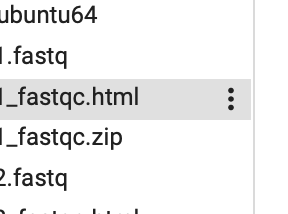

Entonces debería ver algo como esto:

![enter image description here](https://github.com/WCSCourses/ViralBioinfAsia2022/raw/main/course_data/NGS_file_formats_and_data_QC/images/Screenshot%202022-07-31%20at%2015.28.02.png)

Note que hay dos pestañas en el navegador web Firefox; Hay uno para el informe de QC para *SRR19504912_1.Fastq* y otro para *SRR19504912_2.Fastq*.

Hay mucha información de QC en estos informes. Siéntase libre de explorarlos en su propio tiempo y eche un vistazo a la página de inicio de FastQC en https://www.bioinformatics.babraham.ac.uk/projects/fastqc/ y vea el video del tutorial en https://www.youtube.com/watch?v=bz93ReOv87Y.

Por ahora, solo vamos a mirar
- Estadísticas básicas
- Calidad de secuencia por base
- Contenido del adaptador

### Preguntas:

 - ¿Cuántas lecturas de secuencia hay? ¿Su respuesta coincide con tu respuesta anterior (basada en `wc -l`)?

 - Con respecto a los puntajes de calidad, ¿cuál de los dos archivos tiene datos de mejor calidad: *SRR19504912_1.Fastq* o *SRR19504912_2.Fastq*.
 
 - ¿Los conjuntos de datos están contaminados con algún adaptador de secuenciación de Illumina?¿Cuál/es?



## Recorte y filtrado para eliminar secuencias de baja calidad

Cuando inspeccionó los informes FASTQC, probablemente notó que *SRR19504912_1.Fastq* y *SRR19504912_2.Fastq* incluyen algunas lecturas de secuencia que contienen puntajes de calidad muy pobres y algunas lecturas que se derivan de los adaptadores Illumina en lugar de las secuencias objetivo. Ahora, vamos a ver cómo podemos eliminar los datos deficientes y la contaminación recortando y filtrando. Usaremos [Trimgalore] (https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/) ejecutando el siguiente comando:

In [ ]:
!trim_galore -q 25 --length 50 --paired SRR19504912_1.fastq SRR19504912_2.fastq

Ahora, cuando liste el contenido del directorio con `ls -lh, notará dos archivos nuevos llamados *SSRR19504912_1_val_1.fq* y *SRR19504912_2_val_2.fq*. Estas son las versiones recortadas y filtradas de los archivos originales *SRR19504912_1.fastq* y *SRR19504912_2.fastq*. Ahora, ejecutemos fastQC en estos dos nuevos archivos "limpios":


In [ ]:
#Corra el comando ls -lh 

In [ ]:
#Corra fastqc *.fq
!fastqc *.fq


Esto creará informes de control de calidad en formato HTML para los archivos FASTQ limpios. Ahora echemos un vistazo a estos archivos como lo hizo anteriormente descargando el archivo html y abriéndolo en un navegador

### Preguntas:

 - ¿Cuántas lecturas fueron eliminadas por Trimgalore de cada archivo FASTQ?
 - ¿Qué impacto ha tenido Trimgalore sobre la longitud de las lecturas de secuencia?
 - ¿Qué impacto ha tenido Trimgalore en la contaminación de adaptadores?
 - ¿Trimgalore ha alterado la distribución de puntajes de calidad?
 
 Puede leer más sobre Trimgalore en https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/.

___

# Illumina QC

Usaremos el software [fastQC] (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) para el análisis de los resultados de secuenciación de Illumina. FastQC ejecuta una serie de análisis de archivos FASTQ e informa los resultados como un archivo html que abre en un navegador. Para obtener ayuda en cualquiera de las secciones, consulte los siguientes enlaces.

*   [Basic statitistics](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/1%20Basic%20Statistics.html)
*   [Per base sequence quality](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/2%20Per%20Base%20Sequence%20Quality.html)
*   [Per base sequence content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/4%20Per%20Base%20Sequence%20Content.html)
*   [Per sequence GC content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/5%20Per%20Sequence%20GC%20Content.html)
*   [Per base N content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/6%20Per%20Base%20N%20Content.html)
*   [Sequence length distribution](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/7%20Sequence%20Length%20Distribution.html)
*   [Duplicate Sequences](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/8%20Duplicate%20Sequences.html)
*   [Overrepresented Sequences](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/9%20Overrepresented%20Sequences.html)
*   [Adapter content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/10%20Adapter%20Content.html)
*   [Kmer content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/11%20Kmer%20Content.html)
*   [Per tile sequence quality](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/12%20Per%20Tile%20Sequence%20Quality.html)


Ejecute FastQC desde la línea de comandos

In [ ]:
#Cree un directorio para almacenar todos los resultados de FastQC y ejecutar FastQC
!mkdir Illumina_fastqc_results
!fastqc -o Illumina_fastqc_results /content/module_2/illumina/*

Podemos resumir los resultados de FastQC usando MultiQC

In [ ]:
!multiqc -o /content/Illumina_fastqc_results/ /content/Illumina_fastqc_results/

Esto creará un archivo de resultados HTML (`Multiqc_report`) con un resumen de los informes de FastQC.

Revise los resultados para cada archivo e informe:

> **¿Qué muestra tiene más lecturas?**

> **¿Cuál es el tamaño promedio de reads de la muestra SRR19903797?**

___

# Nanopore QC

Ejecute FastQC desde la línea de comandos (en realidad, para nanopore, FastQC no es una buena opción)

In [ ]:
!mkdir Nanopore_FastQC_report
!find /content/module_2/nanopore -type f -exec fastqc -o Nanopore_FastQC_report {} \;

In [ ]:
!multiqc -o /content/Nanopore_FastQC_report/ /content/Nanopore_FastQC_report/

Ejecución de NanoPlot para datos de nanopore

In [ ]:
!find /content/module_2/nanopore -type f -name "*.fastq.gz" -exec NanoPlot -o nanoplot_output --fastq {} \;

 La salida estará en la carpeta NanoPlot_output. Descargue el archivo `nanoplot-report.html` y explore los resultados.


> **¿Cuántas lecturas hay en total?**

> **¿Cuál es el tamaño de lectura promedio?**

*Adaptado de:*

- Advanced Bioinformatics Course developed for the GPS and JUNO projects - Wellcome Sanger Insitute
- SARS-CoV-2 Bioinformatics for Beginners Course - Wellcome Connecting Science
- Viral Genomics and Bioinformatics Asia 2022 - Wellcome Connecting Science


*Modificado por Luisa Sacristán (Universidad de los Andes-CABANA)*